# Composite Figure

## Import package

In [1]:
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from matplotlib import spines as sp
from matplotlib.colors import TwoSlopeNorm

## Figure 01: Raw Composite for the CCKWs in CNTL

### Load data

In [2]:
# file path
path: str = "/work/b11209013/2024_Research/MPAS/merged_data/CNTL/"

# load selected events
sel_events: dict       = np.load(
    "/home/b11209013/Bachelor_Thesis/CCKW_sel/Selected_Events/q1_sel_CNTL.npz",
    allow_pickle=True
    )
sel_time  : np.ndarray = sel_events["selected_events_time"]
sel_lon   : np.ndarray = sel_events["selected_events_lon"]

# load MPAS data
data: dict[str, np.ndarray] = dict()

with nc.Dataset(f"{path}rthratenlw.nc") as f:
    dims: dict[str, np.ndarray] = dict(
        (key, np.array(f.variables[key][:]))
        for key in f.dimensions.keys()
    )

    lat_lim: np.ndarray = np.where(
        (dims["lat"] >= -5) & (dims["lat"] <= 5)
    )[0]

    dims["lat"]  = dims["lat"][lat_lim]
    dims["time"] = dims["time"][:360]

    convert_factor: np.ndarray =  (1000/dims["lev"][None, :, None, None])**-0.286

    data["lw"] = np.array(f.variables["rthratenlw"][:360, :, lat_lim, :])*convert_factor*86400

with nc.Dataset(f"{path}rthratensw.nc") as f:
    data["sw"] = np.array(f.variables["rthratensw"][:360, :, lat_lim, :])*convert_factor*86400

with nc.Dataset(f"{path}theta.nc") as f:
    data["t"] = np.array(f.variables["theta"][:360, :, lat_lim, :])*convert_factor

## Processing data

In [3]:
# averaged over latitude
data = dict(
    (key, np.mean(data[key], axis=2))
    for key in data.keys()
)

# remove climatology and zonal mean
data_rm_cli: dict[str, np.ndarray] = dict(
    (key, data[key] - np.mean(data[key], axis=(0, 2), keepdims=True))
    for key in data.keys()
)

## Events selection

In [4]:
data_sel: dict[str, np.ndarray] = dict()

for key in data_rm_cli.keys():
    temp_data = list()
    for t in range(sel_time.shape[0]): # for seleting time
        for l in sel_lon[t]: # for selecting longitude in each time
            temp_data.append(data_rm_cli[key][sel_time[t], :, l].T)

    data_sel[key] = np.array(temp_data).mean(axis=0)

## Daily mean of radiative heating

In [5]:
lw_daily = np.array([
    data_sel["lw"][:, i*4:(i+1)*4].mean(axis=1)
    for i in range(6)
]).T

sw_daily = np.array([
    data_sel["sw"][:, i*4:(i+1)*4].mean(axis=1)
    for i in range(6)
]).T

print(lw_daily.shape, sw_daily.shape)

(38, 6) (38, 6)


### Composite

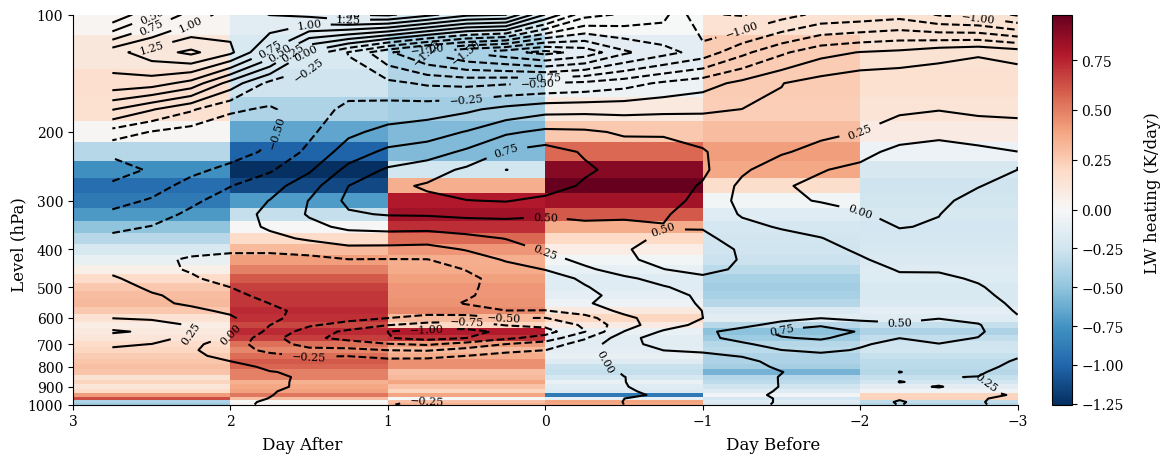

In [6]:
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(12, 5))
pc = plt.pcolormesh(
    np.linspace(-2.5, 2.5, 6), dims["lev"], lw_daily,
    cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0)
    )
c1 = plt.contour(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["t"],
    colors="k",
    levels=np.arange(-1.75, 1.51, 0.25)
    )
plt.yscale("log")
plt.xticks(np.linspace(-3, 3, 7))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.ylim(100, 1000)
plt.text(1.8, 1300, "Day After", fontsize=12)
plt.text(-1.15, 1300, "Day Before", fontsize=12)
plt.text(3.4, 500, "Level (hPa)", fontsize=12, rotation=90)
plt.text(-3.8, 450, r"LW heating (K/day)", fontsize=12, rotation=90)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(pc, pad=0.03)
plt.clabel(c1, inline=True, fontsize=8)
plt.subplots_adjust(left=0.07, right=1.03, top=0.9, bottom=0.12)

axes = fig.gca()
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)

plt.savefig("LW_profile.png", dpi=300)

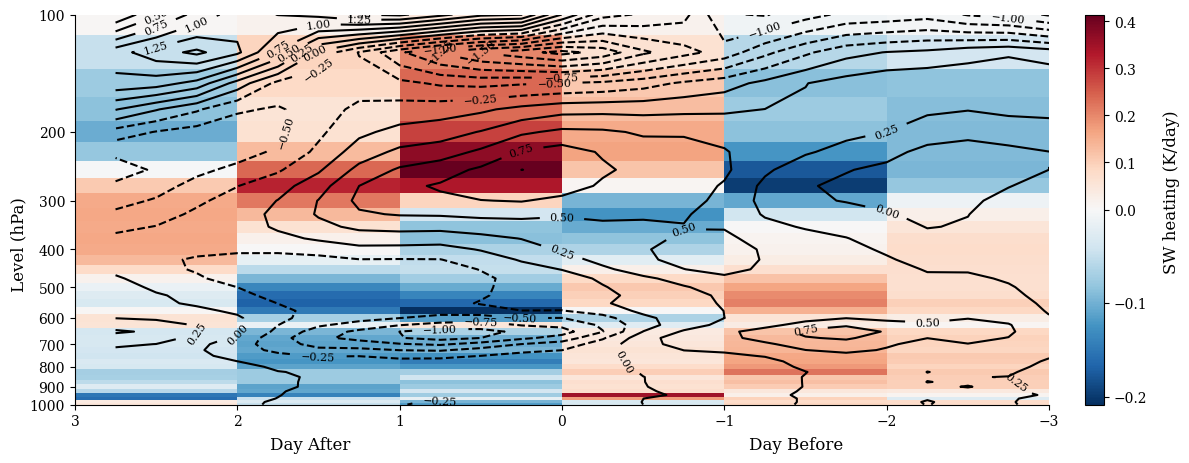

In [7]:
plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(12, 5))
pc = plt.pcolormesh(
    np.linspace(-2.5, 2.5, 6), dims["lev"], sw_daily,
    cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0)
    )
c1 = plt.contour(
    np.linspace(-3, 2.75, 24), dims["lev"], data_sel["t"],
    colors="k",
    levels=np.arange(-1.75, 1.51, 0.25)
    )
plt.yscale("log")
plt.xticks(np.linspace(-3, 3, 7))
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.ylim(100, 1000)
plt.text(1.8, 1300, "Day After", fontsize=12)
plt.text(-1.15, 1300, "Day Before", fontsize=12)
plt.text(3.4, 500, "Level (hPa)", fontsize=12, rotation=90)
plt.text(-3.7, 450, r"SW heating (K/day)", fontsize=12, rotation=90)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(pc, pad=0.03)
plt.clabel(c1, inline=True, fontsize=8)
plt.subplots_adjust(left=0.07, right=1.06, top=0.9, bottom=0.12)

axes = fig.gca()
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)

plt.savefig("SW_profile.png", dpi=300)